# Grupo 4


| Nombre  | Padrón |
| ------------- | ------------- |
| Ian Gauler | 109437  |
| Valentina Gemetto  | 109667  |
| Agustin Puglisi  | 104245 |
| Ezequiel Vilardo  | 104980  |

In [38]:
# Importamos mersenne twister de nuestra implementacion
from mersenne_twister import MersenneTwister

---

# Ejercicio 1 

Un servidor recibe solicitudes las cuales son procesadas de una por vez en el orden de llegada (política FIFO).\
Se determinó que en 10 milisegundos existe una probabilidad p = 1/40 que llegue una nueva solicitud y q = 1/30 que una solicitud termine de ser procesada y deje el sistema.\
Se desea estudiar la cantidad de solicitudes en el servidor considerando tanto las que están en cola esperando ser 
procesadas como la solicitud que está siendo procesada. 
 
a. Determine la matriz de transición de estados explicando cómo se obtiene la misma.\
b. Simule, utilizando el generador de números al azar desarrollado en el tp 1, la evolución del sistema a lo largo de 
1.500 segundos. Suponga que el servidor comienza sin estar procesando solicitudes.\
c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.\
d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.\
e. Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

---

### a. Determine la matriz de transición de estados explicando cómo se obtiene la misma.

Los datos que da el enunciado son:
- Llega una nueva solicitud. Con probabilidad $p = 1/40$.
- Se termina de procesar una solicitud. Con probabilidad $q = 1/30$.

Si bien al arrrancar el ejercicio pensamos en que lo que podría ocurrir es que solamente podría llegar una solicitud o procesarse otra, luego decidimos que podría suceder que en un lapso de tiempo podría llegar una solicitud, pero al mismo tiempo, otra se podría estar procesando. Entonces esta última podría terminar en el mismo lapso de tiempo que llega la nueva solicitud. Por lo tanto, en un lapso de tiempo podría llegar una solicitud y procesarse otra.

En pruebas simuladas, ambos casos dieron el mismo resultado. Por lo que decidimos quedarnos con el caso mas complejo.

A continuación presentamos la matriz de transición de estados. En la misma, las filas representan el estado actual del sistema y las columnas el estado siguiente.\
Por ejemplo: 
* La celda (0, 0) representa la probabilidad de que el sistema se mantenga en el estado 0 (sin solicitudes).
* La celda (0, 1) representa la probabilidad de que el sistema pase del estado 0 (sin solicitudes) al estado 1 (con una solicitud en proceso). 
* La celda (1, 2) representa la probabilidad de que el sistema pase del estado 1 (con una solicitud en proceso) al estado 2 (con una solicitud en proceso y una en cola).
* La celda (2, 1) representa la probabilidad de que el sistema pase del estado 2 (con una solicitud en proceso y una en cola) al estado 1 (con una solicitud en proceso).

Los eventos que pueden ocurrir son:
* Para el caso en que el sistema se encuentra sin solicitudes:
    * Llega una nueva solicitud, pasa a un estado con una solicitud. Con probabilidad $p = 1/40$.
    * No llega una nueva solicitud, se mantiene en el mismo estado. Con probabilidad $1 - p = 39/.
<br><br>
* Para el caso en que el sistema se encuentra con una o más solicitudes:
    * No llega una solicitud y se procesa una solicitud, pasa a un estado con una solicitud menos. Con probabilidad $q\overline{p}$.
    * Llega una solicitud y no se procesa una solicitud, pasa a un estado con una solicitud más. Con probabilidad $p\overline{q}$.
    * Llega una solicitud y se procesa una solicitud o, no ocurre ningún evento, se mantiene en el mismo estado. Con probabilidad $ r = 1 - q\overline{p} - p\overline{q}$.
<br><br>
* Para el caso en que el sistema se encuentra en el último instante de simulación:
    * Se procesa una solicitud, pasa a un estado con una solicitud menos. Con probabilidad $q$.
    * No se procesa una solicitud, se mantiene en el mismo estado. Con probabilidad $\overline{q}$.

\begin{bmatrix}

    \overline{p} & p & 0 & 0 & 0 & ... & 0 & 0 & 0 \\
    q\overline{p} & r & p\overline{q} & 0 & ... & 0 & 0 & 0 \\
    0 & q\overline{p} & r & p\overline{q} & 0 & ... & 0 & 0 & 0 \\
    ... & ... & ... & ... & ... & ... & ... & ... & ... \\
    0 & 0 & 0 & 0 & 0 & ... & q\overline{p} & r & p\overline{q} \\
    0 & 0 & 0 & 0 & 0 & ... & 0 & q & \overline{q} \\   
     
\end{bmatrix}


Para la matriz necesitamos conocer la cantidad de estados posibles. Es decir, la cantidad máxima de estados posibles viene dada por el tiempo de simulación (1500 segundos) dividido por el tiempo que tarda en ocurrir un evento (10 milisegundos).\
Por lo tanto, la cantidad de estados posibles es $1500 / 0.01 = 150000$.

In [39]:
import scipy.sparse as sp
import numpy as np

# Tamaño de la matriz y probabilidades de transición
n = 150000
p = 1 / 40
q = 1 / 30
r = 1 - (q * (1 - p) + p * (1 - q))

# Crear una matriz dispersa, inicialmente llena de ceros
matrix = sp.lil_matrix((n, n), dtype=np.float64)

for i in range(1, n):
    matrix[i, i] = r  # Valores en la diagonal principal
    matrix[i - 1, i] = p * (1 - q)  # Valores en la diagonal superior
    matrix[i, i - 1] = q * (1 - p)  # Valores en la diagonal inferior

matrix[0, 0] = 1 - p
matrix[0, 1] = p
matrix[n - 1, n - 2] = q
matrix[n - 1, n - 1] = 1 - q

matrix = matrix.tocsr()

### b. Simule, utilizando el generador de números al azar desarrollado en el tp 1, la evolución del sistema a lo largo de 1.500 segundos. Suponga que el servidor comienza sin estar procesando solicitudes.

In [40]:
mer_twis = MersenneTwister(0)

In [41]:
def simular_solicitudes(tiempo_simulacion, step):
    cantidad_en_cola = 0
    cantidad_procesados = 0
    solicitudes_por_tiempo = []
    cant_por_estado = {}

    for _ in range(0, tiempo_simulacion, step):
        probabilidad = mer_twis.uniform()

        if cantidad_en_cola == 0:
            if probabilidad < p:
                cantidad_en_cola += 1
        else:
            if probabilidad < q * (1 - p):
                cantidad_en_cola -= 1
                cantidad_procesados += 1

            elif probabilidad < q * (1 - p) + p * (1 - q):
                cantidad_en_cola += 1

            else:
                cantidad_procesados += 1

        # plasmamos el resultado en solicitudes_por_tiempo
        solicitudes_por_tiempo.append(cantidad_en_cola)
        if cantidad_en_cola in cant_por_estado:
            cant_por_estado[cantidad_en_cola] += 1
        else:
            cant_por_estado[cantidad_en_cola] = 1

    return (
        cantidad_procesados,
        cantidad_en_cola,
        solicitudes_por_tiempo,
        cant_por_estado,
    )

In [42]:
(
    cantidad_procesados,
    cantidad_en_cola,
    solicitudes_por_tiempo,
    cant_por_estado,
) = simular_solicitudes(150000, 1)

print(f"Procesados: {cantidad_procesados}")
print(f"En cola: {cantidad_en_cola}")

Procesados: 112730
En cola: 2


### c. Realice un gráfico mostrando la cantidad de solicitudes en el servidor en cada instante de tiempo.

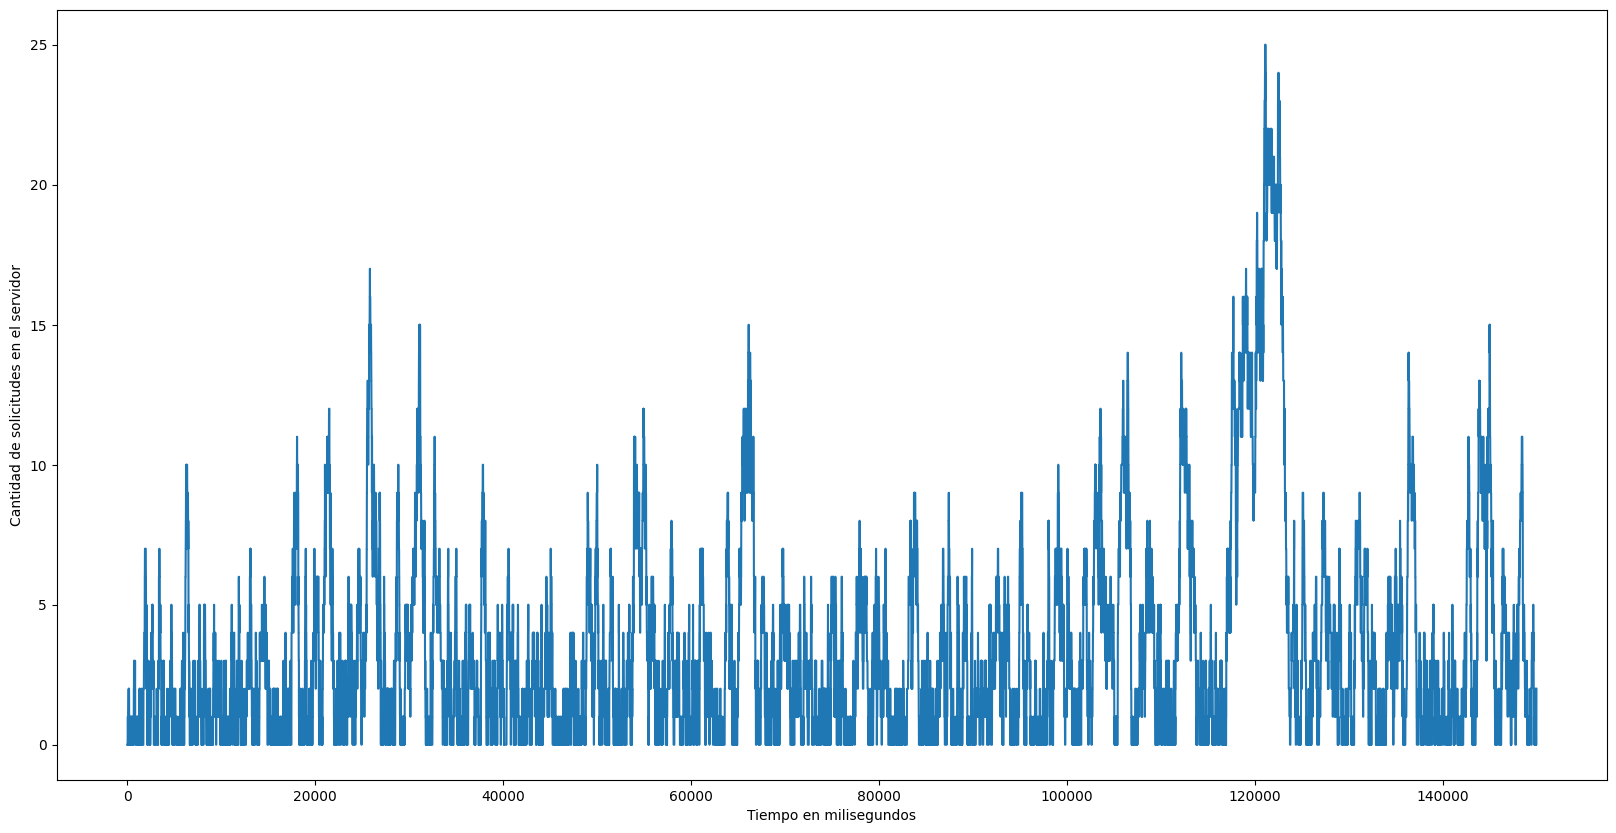

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(solicitudes_por_tiempo)
plt.xlabel("Tiempo en milisegundos")
plt.ylabel("Cantidad de solicitudes en el servidor")
plt.show()

### d. Realice un histograma mostrando cuantas veces el sistema estuvo en cada estado.

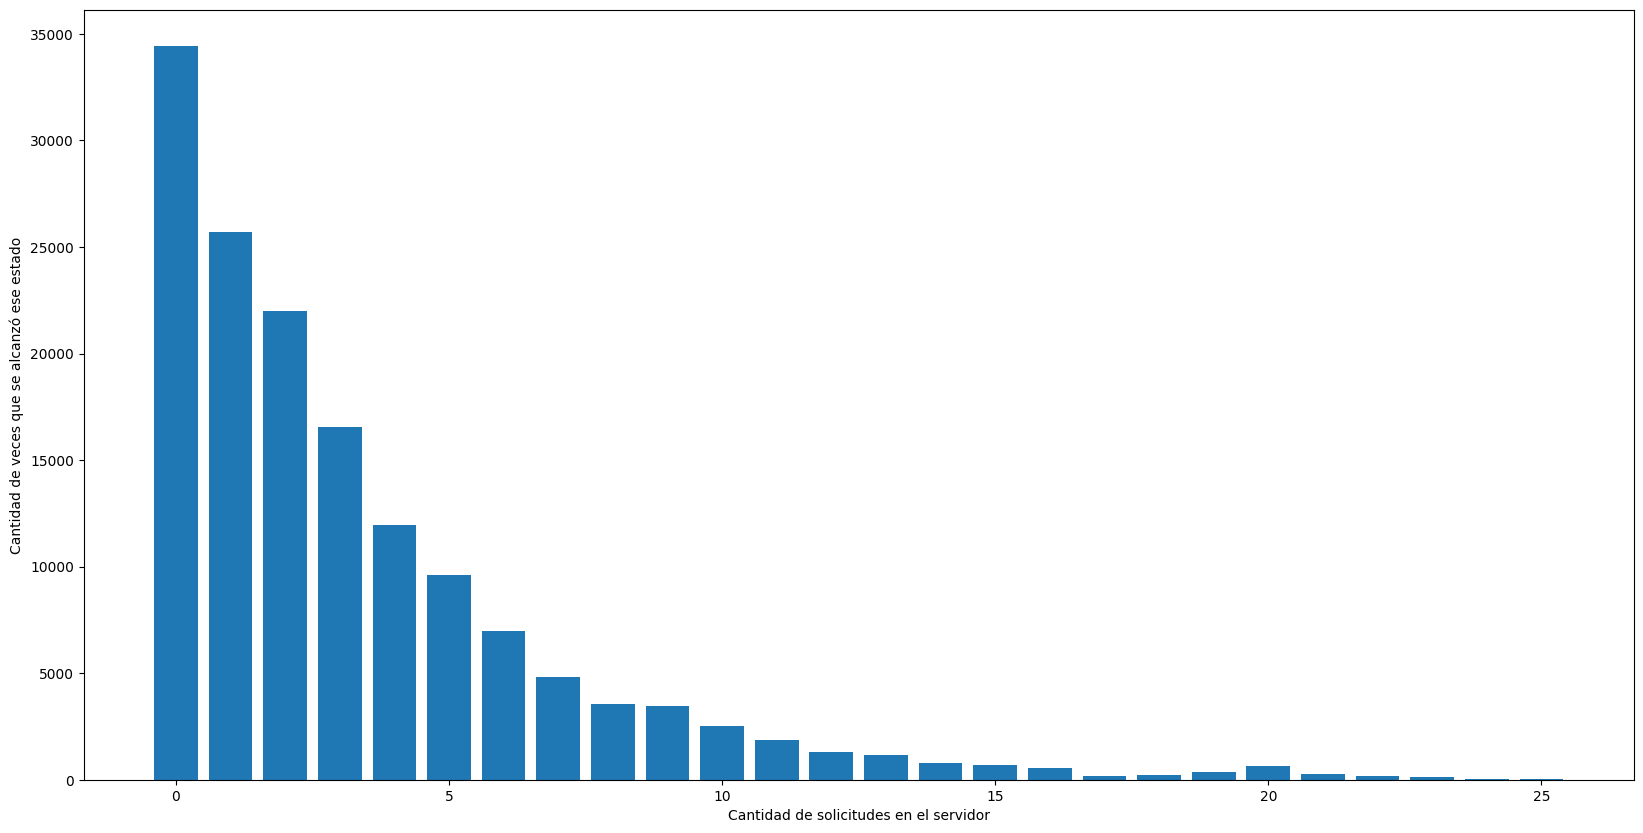

In [44]:
plt.figure(figsize=(20, 10))
plt.bar(cant_por_estado.keys(), cant_por_estado.values())
plt.xlabel("Cantidad de solicitudes en el servidor")
plt.ylabel("Cantidad de veces que se alcanzó ese estado")
plt.show()

In [45]:
cant_tiempo_sin_procesar = cant_por_estado[0]

cant_tiempo_procesado = sum(cant_por_estado.values()) - cant_tiempo_sin_procesar

print(f"Tiempo sin procesar: {cant_tiempo_sin_procesar} milisegundos")

Tiempo sin procesar: 34416 milisegundos


### e. Determine el % de tiempo que el servidor se encuentra sin procesar solicitudes.

In [46]:
tiempo_simulacion = 1500

porcentaje_sin_procesar = cant_tiempo_sin_procesar / tiempo_simulacion

print(
    f"El servidor se encuentra sin procesar solicitudes durante un {porcentaje_sin_procesar:.3f}% del tiempo."
)

El servidor se encuentra sin procesar solicitudes durante un 22.944% del tiempo.


---
# Ejercicio 2

Junto con el mismo grupo asignado para el ejercicio 3 se deben simular las 2 alternativas planteadas. Cada grupo 
debe elegir una arquitectura y simularla, luego entre ambos deben concluir la mejor opción a implementar. 
Resolver planteando una simulación de tipo Montecarlo. 
Se está diseñando un web service, el cual cada vez que es invocado consulta a una base de datos. 
Se estima que el tiempo que transcurre entre cada llamada al servicio se puede modelar según una 
distribución  exponencial con media =4 segundos
 
Se debe decidir la arquitectura de base de datos a utilizar entre las dos siguientes: 
1. Utilizar 2 bases de datos distribuidas. 
Con probabilidad p=0.7 las solicitudes son atendidas por la base 1 y con probabilidad q=1-p son atendidos por la 
base de datos 2. 
El  tiempo  que  demora  cada  base  de  datos  en  atender  una  solicitud  sigue  una  distribución  exponencial  con 
medias,  1=0,7 seg  y 2=1 seg respectivamente. 
2. Utilizar 1 base de datos central. 
En este caso la demora en resolver una solicitud sigue una distribución exponencial con =0,8 segundos.

Simular para cada opción 100.000 solicitudes procesadas, determinando:

• El  tiempo  medio  de  espera  entre  que  la  solicitud  llega  y  puede  ser  procesada  (suponer  que  ninguna 
conexión cae por timeout).\
• La fracción de las solicitudes que no esperaron para ser procesadas.

---

In [47]:
import matplotlib.pyplot as plt
import random

np.random.seed(11)

In [48]:
mediaArribos = 4
mediaBase1 = 0.7
mediaBase2 = 1
cantSolicitudes = 100000
p = 0.7


def muestraDeArribos():
    return np.random.exponential(mediaArribos)


def simulacionTiempoDeAtendimiento():
    if np.random.rand() < p:
        return np.random.exponential(mediaBase1)
    else:
        return np.random.exponential(mediaBase2)


def simulacionBaseDistribuida(cantSolicitudes):
    tiemposEspera = []
    tiempoDeLlegada = 0
    tiempoListoParaProcesar = 0
    tiempoSolicitudes = []

    for _ in range(cantSolicitudes):
        tiempoDeLlegada += muestraDeArribos()
        tiempoDeAtendimiento = simulacionTiempoDeAtendimiento()
        tiempoEsperaDeMuestra = tiempoListoParaProcesar - tiempoDeLlegada

        if tiempoEsperaDeMuestra > 0:
            tiemposEspera.append(tiempoDeAtendimiento)
            solicitud = tiempoDeAtendimiento + tiempoEsperaDeMuestra
            tiempoSolicitudes.append(solicitud)

        else:
            tiemposEspera.append(0)
            tiempoSolicitudes.append(tiempoDeAtendimiento)

        tiempoListoParaProcesar = tiempoDeLlegada + tiempoDeAtendimiento

    return tiemposEspera, tiempoSolicitudes


tiemposEsperaA1, tiempoSolicitudesA1 = simulacionBaseDistribuida(cantSolicitudes)

In [49]:
print("Tiempo medio de espera: {} segundos".format(np.mean(tiemposEsperaA1)))

print(
    "Fracción de solicitudes que no esperaron para ser procesadas: {}%".format(
        (tiemposEsperaA1.count(0) / cantSolicitudes) * 100
    )
)

Tiempo medio de espera: 0.12663220078921225 segundos
Fracción de solicitudes que no esperaron para ser procesadas: 83.827%


Utilizando solo una base central, de acuerdo a los datos proporcionados por el grupo 3 sabemos que:

Tiempo medio de espera para 1 base: 0.202 segundos

Fracción de solicitudes que no esperaron para ser procesadas para 1 base: 80.09%

En base a los resultados observamos que al incorporar una arquitectura que utilice bases distribuidas, como era de esperarse mejoramos la eficiencia en términos de tiempos de espera. Sin embargo estas mejoras no parecen ser muy significativas ya que solo logramos mejorar el tiempo de espera en aproximadamente 0.1 segundo, y la fracción de solicitudes que no esperan a ser procesadas solo aumentan en 3%.

---

# Ejercicio 3 
En base al trabajo “SIMULATION OF LOAD BALANCING ALGORITHMS: A Comparative Study”, y utilizando Simpy, se pide simular un balanceador de carga siguiendo las siguientes técnicas:

• Difusa (propuesta en el trabajo).\
• La técnica asignada a cada grupo, la cual se encuentra publicada en la planilla de grupos.\
• Nueva técnica propuesta por el grupo

Cada grupo debe trabajar con otro equipo, donde cada uno implementará, salvo la estrategia Difusa, estrategias diferentes, para luego ser comparadas y analizar los resultados en conjunto.
 
Cada grupo debe proponer distintos parámetros para la simulación siendo estos:

• Tasa de arribos de requerimientos.\
• Tiempo de procesamiento por el balanceador, o tiempo en derivar el pedido.\
• Tiempo de procesamiento del requerimiento en el servidor destino.\
• Cantidad de servidores (se debe incluir la opción de 5 servidores evaluada en el trabajo)
 
Este ejercicio apunta a ser un trabajo de exploración, donde puedan modificar los parámetros buscando umbrales donde la decisión entre los distintos métodos no sea tan clara.
Suponer procesos de Poisson

Simular al menos 2 situaciones para cada técnica, comparando los resultados obtenidos. 
Generar distribuciones para las variables tiempo en espera y tiempo de atención en los servidores, y medidas de 
resumen como media, mediana, y desvío estándar para poder comparar las alternativas.

---

Las tecnicas a implementar son:

DIFFUSE LOAD -> Para la cual usaremos un diferencial de 2

SHORTEST QUEUE

LEAST RESPONSE TIME

Para modelar el costo de procesamiento de las tareas, se modelaron 3 diferentes: 

una con prob 0.25 -> con probabilidad uniforme de tardar entre 50 y 100 ms

otra con prob 0.25 -> con probabilidad uniforme de tardar entre 100 y 150 ms

y la ultima con prob 0.50 -> con probabilidad uniforme de tardar entre 150 y 200 ms

In [91]:
import random as rnd
import numpy as np
import simpy

RANDOM_SEED = 99999
diferencial = 2

In [130]:
tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]


class Solicitud:
    def __init__(self, env, lista_con_tiempos_procesamiento, numero):
        self.env = env
        self.tiempo_ejecucion = self.generarTiempoEjecucion()
        self.tiempo_procesamiento = None
        self.lista_tiempos = lista_con_tiempos_procesamiento
        self.numero_servidor = numero

    def ejecutar(self, servidor):
        with servidor.request() as req:
            self.tiempo_procesamiento = self.env.now
            yield req
            yield self.env.timeout(self.tiempo_ejecucion)
            self.tiempo_procesamiento = (
                self.env.now - self.tiempo_procesamiento
            )  # el tiempo sera lo que tardo entre que pidio el recurso y lo termino de usar (final - inicial)
            cola_servidor[self.numero_servidor] -= 1
            self.lista_tiempos.append(self.tiempo_procesamiento)
            cant_solicitudes[self.numero_servidor] += 1
            tiempo_total_servidor[self.numero_servidor] += self.tiempo_procesamiento
            predictivo_promedio[self.numero_servidor] = (
                tiempo_total_servidor[self.numero_servidor]
                / cant_solicitudes[self.numero_servidor]
            )

    def generarTiempoEjecucion(self):
        uniforme = rnd.random()
        if uniforme <= 0.25:
            return rnd.uniform(50, 100)
        if uniforme <= 0.50:
            return rnd.uniform(100, 150)
        return rnd.uniform(150, 200)


def generar_solicitudes(environment, count, tasa_arribos, politica):
    servidores = [simpy.Resource(env) for i in range(5)]
    servidor_a_asignar = 0
    cola_servidor[servidor_a_asignar] += 1
    for i in range(count):
        solicitud = Solicitud(env, tiempos, servidor_a_asignar)
        environment.process(solicitud.ejecutar(servidores[servidor_a_asignar]))
        t = rnd.expovariate(tasa_arribos)
        yield environment.timeout(t)
        match politica:
            case "diffuse":
                servidor_a_asignar = (servidor_a_asignar + 1) % 5
                for i in range(len(cola_servidor)):
                    if cola_servidor[servidor_a_asignar] >= (
                        cola_servidor[i] + diferencial
                    ):
                        servidor_a_asignar = i
                cola_servidor[servidor_a_asignar] += 1

            case "shortest_queue":
                minimo = min(cola_servidor)
                servidor_a_asignar = cola_servidor.index(minimo)
                cola_servidor[servidor_a_asignar] += 1

            case "least_response_time":
                minimo = min(predictivo_promedio)
                servidor_a_asignar = predictivo_promedio.index(minimo)
                cola_servidor[servidor_a_asignar] += 1

        #print(cola_servidor) #Te permite ver como se van distribuyendo las tareas en los servidores

Simulamos con las 3 tecnicas, arrancamos primero con 1 millon de iteraciones y con una tasa de arribos de 1/50

In [125]:
iteraciones = 1000000
tasa_arribos = 1/50

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "diffuse"))
env.run()  # termina cuando todos atendidos
print("DIFFUSE LOAD -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON DIFFUSE LOAD: ",sum(tiempos) / len(tiempos))
print("MEDIANA CON DIFFUSE LOAD: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON DIFFUSE LOAD: ", np.std(tiempos))
print('-------------------------------------')

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "shortest_queue"))
env.run()  # termina cuando todos atendidos
print("SHORTEST QUEUE -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON SHORTEST QUEUE: ", sum(tiempos) / len(tiempos))
print("MEDIANA CON SHORTEST QUEUE: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON SHORTEST QUEUE: ", np.std(tiempos))
print('-------------------------------------')

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "least_response_time"))
env.run()  # termina cuando todos atendidos
print("LEAST RESPONSE TIME -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON LEAST RESPONSE TIME: ", sum(tiempos) / len(tiempos))
print("MEDIANA CON LEAST RESPONSE TIME: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON LEAST RESPONSE TIME: ", np.std(tiempos))
print('-------------------------------------')

DIFFUSE LOAD -> Tardo 50005844.93981841 milisegundos en ejecutar
PROMEDIO CON DIFFUSE LOAD:  148.08692960676493
MEDIANA CON DIFFUSE LOAD:  155.43566816337238
DESVIACION ESTANDARD CON DIFFUSE LOAD:  52.19925074426363
-------------------------------------
SHORTEST QUEUE -> Tardo 50021609.23525682 milisegundos en ejecutar
PROMEDIO CON SHORTEST QUEUE:  148.78093944027418
MEDIANA CON SHORTEST QUEUE:  155.11202344624326
DESVIACION ESTANDARD CON SHORTEST QUEUE:  55.672752940247754
-------------------------------------
LEAST RESPONSE TIME -> Tardo 63708961.436039805 milisegundos en ejecutar
PROMEDIO CON LEAST RESPONSE TIME:  4411244.491867877
MEDIANA CON LEAST RESPONSE TIME:  3554020.0082280645
DESVIACION ESTANDARD CON LEAST RESPONSE TIME:  3541412.9382590754
-------------------------------------


Podemos ver que la tecnica difusa y la de cola mas corta se encuentran con tiempos similares pero la de menor tiempo de respuesta tiene tiempos muchos mas grandes...
Intuimos que se debe a que llegan nuevas tareas antes que terminen otras acumulandose en el mismo servidor hasta que se actualiza el tiempo de respuesta y ahi comienzan a derivarse a otro servidor.
A continuacion probamos bajando la tasa de arribos, en teoria suponemos que deberia mejorarse los tiempos ya que tendra mas tiempo para evolucionar el indicador de tiempo de respuesta.

In [126]:
iteraciones = 1000000
tasa_arribos = 1/1000

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "diffuse"))
env.run()  # termina cuando todos atendidos
print("DIFFUSE LOAD -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON DIFFUSE LOAD: ",sum(tiempos) / len(tiempos))
print("MEDIANA CON DIFFUSE LOAD: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON DIFFUSE LOAD: ", np.std(tiempos))
print('-------------------------------------')

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "shortest_queue"))
env.run()  # termina cuando todos atendidos
print("SHORTEST QUEUE -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON SHORTEST QUEUE: ", sum(tiempos) / len(tiempos))
print("MEDIANA CON SHORTEST QUEUE: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON SHORTEST QUEUE: ", np.std(tiempos))
print('-------------------------------------')

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "least_response_time"))
env.run()  # termina cuando todos atendidos
print("LEAST RESPONSE TIME -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON LEAST RESPONSE TIME: ", sum(tiempos) / len(tiempos))
print("MEDIANA CON LEAST RESPONSE TIME: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON LEAST RESPONSE TIME: ", np.std(tiempos))
print('-------------------------------------')

DIFFUSE LOAD -> Tardo 999336671.247397 milisegundos en ejecutar
PROMEDIO CON DIFFUSE LOAD:  137.45668562589663
MEDIANA CON DIFFUSE LOAD:  149.88039469718933
DESVIACION ESTANDARD CON DIFFUSE LOAD:  43.93542089959749
-------------------------------------
SHORTEST QUEUE -> Tardo 1000599706.6170832 milisegundos en ejecutar
PROMEDIO CON SHORTEST QUEUE:  137.5081201686363
MEDIANA CON SHORTEST QUEUE:  150.03918139636517
DESVIACION ESTANDARD CON SHORTEST QUEUE:  43.904419282487844
-------------------------------------
LEAST RESPONSE TIME -> Tardo 999505467.065758 milisegundos en ejecutar
PROMEDIO CON LEAST RESPONSE TIME:  149.57831206348965
MEDIANA CON LEAST RESPONSE TIME:  155.142908369191
DESVIACION ESTANDARD CON LEAST RESPONSE TIME:  58.049629112136934
-------------------------------------


Bien podemos ver que se acerco a nuestra hipotesis, si bien sigue siendo un poco peor (mayor tiempo promedio), los tiempos de las 3 tecnicas se acercaron bastante.
Vamos a hacer una ultima prueba bajando las iteraciones pero aumentando la tasa de arribos. Buscamos que se acumulen man solicitudes en los servidores por lo que empeorara bastante
el tiempo promedio pero no deberia haber tanta diferencia con la tercer tecnica comparado a la primera situacion simulada.

In [131]:
iteraciones = 100000
tasa_arribos = 10

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "diffuse"))
env.run()  # termina cuando todos atendidos
print("DIFFUSE LOAD -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON DIFFUSE LOAD: ",sum(tiempos) / len(tiempos))
print("MEDIANA CON DIFFUSE LOAD: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON DIFFUSE LOAD: ", np.std(tiempos))
print('-------------------------------------')

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "shortest_queue"))
env.run()  # termina cuando todos atendidos
print("SHORTEST QUEUE -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON SHORTEST QUEUE: ", sum(tiempos) / len(tiempos))
print("MEDIANA CON SHORTEST QUEUE: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON SHORTEST QUEUE: ", np.std(tiempos))
print('-------------------------------------')

tiempos = []
cola_servidor = [0, 0, 0, 0, 0]
predictivo_promedio = [0, 0, 0, 0, 0]
cant_solicitudes = [0, 0, 0, 0, 0]
tiempo_total_servidor = [0, 0, 0, 0, 0]

env = simpy.Environment()
env.process(generar_solicitudes(env, iteraciones, tasa_arribos, "least_response_time"))
env.run()  # termina cuando todos atendidos
print("LEAST RESPONSE TIME -> Tardo {} milisegundos en ejecutar".format(env.now))
print("PROMEDIO CON LEAST RESPONSE TIME: ", sum(tiempos) / len(tiempos))
print("MEDIANA CON LEAST RESPONSE TIME: ", np.median(tiempos))
print("DESVIACION ESTANDARD CON LEAST RESPONSE TIME: ", np.std(tiempos))
print('-------------------------------------')

DIFFUSE LOAD -> Tardo 2754433.565226819 milisegundos en ejecutar
PROMEDIO CON DIFFUSE LOAD:  1368912.265502292
MEDIANA CON DIFFUSE LOAD:  1369526.3068589189
DESVIACION ESTANDARD CON DIFFUSE LOAD:  790564.8691468936
-------------------------------------
SHORTEST QUEUE -> Tardo 2752445.8982596225 milisegundos en ejecutar
PROMEDIO CON SHORTEST QUEUE:  1367744.4142878316
MEDIANA CON SHORTEST QUEUE:  1367552.9778697065
DESVIACION ESTANDARD CON SHORTEST QUEUE:  790276.258088485
-------------------------------------
LEAST RESPONSE TIME -> Tardo 6727344.637399147 milisegundos en ejecutar
PROMEDIO CON LEAST RESPONSE TIME:  3106530.209748206
MEDIANA CON LEAST RESPONSE TIME:  3089105.1427132357
DESVIACION ESTANDARD CON LEAST RESPONSE TIME:  1964809.6669174477
-------------------------------------


Se puede apreciar que nuevamente la ultima tecnica tiene tiempos mayores a las otras, como suponiamos en un principio cuando elegimos esta tecnica para implementar, el no tener una ponderacion de cuantas tareas se encuentran ya en cola por mas bueno que sea el promedio de respuesta actual terminaria saturando el servidor. Claro que como vimos en la prueba 2 si la tasa de arribos no es tan alta, esta tecnica se equipara a las otras 2.
En cuanto a las otras 2 tecnicas, para las situaciones probadas no se encontraron diferencias significativas que permitieran decir que una sea mejor a la otra, creemos que se debe a como el diferencial usado en la tecnica difusa es "bajo", termina equilibrandose funcionando de una manera similar al metodo de menor cola.

---

# Ejercicio 4 

El siguiente sistema dinámico es conocido como “Modelo de la telaraña”.\
Mediante el mismo se puede modelar la formación de precios de productos cuya oferta se establece en función el precio de mercado en el período de tiempo anterior.

\begin{equation}
\left\{
    
\begin{aligned}
Q_{1}^{demanda} &= a - bP_{t} \\
Q{t}^{oferta} &= dP_{t-1} - c \\
Q_{t}^{demanda} &= Q_{t}^{oferta} = Q_{t} \\
\end{aligned}

\right.
\end{equation}

Con $a=9,\ b=1.1,\ c=0.4,\ d=1,\ P_{0}=8$

Se pide:\
a. Realizar un análisis de estabilidad de los puntos de equilibrio.\
b. ¿Cómo afectan las condiciones iniciales al sistema? Justifique.\
c. Simular, utilizando el generador de números al azar implementado en el TP 1 el sistema para distintas.\
condiciones iniciales e interprete los resultados.\
d. Graficar la variable precio en función del período (t) para 100 períodos.\
e. Graficar las trayectorias en el espacio de fases del sistema a través de 100 períodos para pares ordenados 
(Qt , Pt).\
f. Simular, utilizando el generador de números al azar implementado en el TP 1, el sistema distintos valores de los parámetros a,b,c,d y P0 y vuelva a realizar los ítems a,b,c,d, y e para cada juego de parámetros probados.
 
---

### a. Realizar un análisis de estabilidad de los puntos de equilibrio

Si reemplazamos la tercera ecuación en las dos primeras y despejamos Q(t) y P(t) el sistema quedariía:

*   P(t) = (a - Q(t)) / b
*   Q(t) = d * P(t-1) - c

Para encontrar los puntos de quilibrio planteamos las condiciones:

*   P(t) = P(t-1) = P
*   Q(t) = Q(t-1) = Q

Quedando así:

*   P = (a - Q) / b
*   Q = d * P - c

Entonces, resolviendo el sistema de ecuaciones:
(P, Q) = ((a+c)/(b+d), d*(a+c)/(b+d) - c)

Reemplazando los datos del enunciado quedaría:
(P, Q) = (4.48, 4.08)


**Análisis de estabilidad:**

Reemplazando la segunda ecuacion en la primera quedaría:

*   P(t) = (a - (d * P(t-1) - c)) / b
*   Q(t) = d * P(t-1) - c

Reordenando la primera ecuación:

*   P(t) = -(d/b)*P(t-1) + (a+c)/b
*   Q(t) = d * P(t-1) - c

Defino la matriz jacobiana J:
\begin{bmatrix}
 -(d/b)&0 \\
 d& 0
\end{bmatrix}

Busco los autovalores de J:

det(J−λI)=0

\begin{vmatrix}
-(d/b) - λ & 0\\
 d& -λ
\end{vmatrix}

= (-(d/b) - λ) * (-λ) = 0

Entonces los autovalores son:

*   λ1 = 0
*   λ2 = - (d/b)

Reemplazamos los valores del enunciado b = 1,1 y d = 1:

*   λ1 = 0
*   λ2 = - (1/1,1) = -0,91

Dado que |λ1|, |λ2| < 1 el punto de equilibrio (P, Q) = (4.48, 4.08) es ESTABLE.

### b. ¿Cómo afectan las condiciones iniciales al sistema? Justifique.

Dado que uno de los autovalores está definido como λ = - (d/b), los parámetros d y b definen la estabilidad del punto de equilibrio, y por lo tanto definen si el sistema converge o no al punto de equilibrio. El parámetro b respresenta el módulo de la pendiente de la recta de demanda, y el parámetro d representa el módulo de la pendiente de la recta de oferta. Por lo tanto, si la pendiente de la recta de demanda es mayor en módulo que la recta de oferta, como es el caso del enunciado, el sistema converge al punto de equilibrio. En cambio, si la pendiente de la recta de demanda es menor en módulo que la recta de oferta, el sistema diverge. Por último, d y b son iguales, el sistema tiende a una fluctuación continua entre determinados valores.

Dado que la convergencia del sistema depende sólo de los parámetros d y b, es independiente de las condiciones iniciales, es decir, del precio inicial. El precio inicial no afecta el comportamiento del sistema.

### c. Simular, utilizando el generador de números al azar implementado en el TP 1 el sistema para distintas condiciones iniciales e interprete los resultados.

Si igualamos las ecuaciones 1 y 2:

Qd(t) = - b*P(t) + a

Qs(t) = d * P(t-1) - c

El precio en función del período estaría dado por la ecuación:

P(t) = (a + c - d * P(t - 1)) / b

con P(0) = P_0

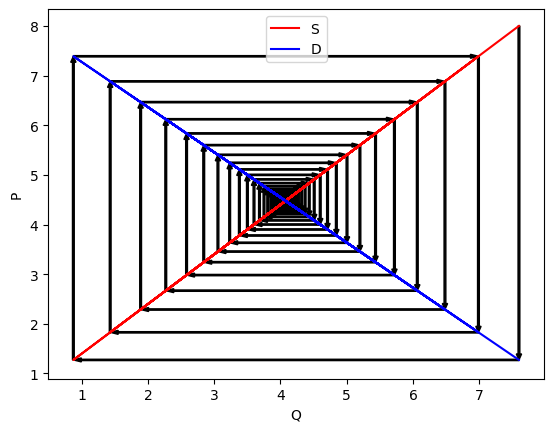

In [54]:
generador = MersenneTwister(0)


def precio_en_funcion_del_periodo(a, b, c, d, P_0, periodo):
    P = [x for x in range(periodo)]
    P[0] = P_0
    for t in range(1, periodo):
        P[t] = (a + c - d * P[t - 1]) / b
    return P


def simular(a, b, c, d, P_0, periodo):
    P = precio_en_funcion_del_periodo(a, b, c, d, P_0, periodo)
    Q_d = []
    Q_s = []
    for t in range(1, periodo):
        Q_d.append(a - b * P[t])
        Q_s.append(d * P[t - 1] - c)
    return P, Q_d, Q_s


a = 9
b = 1.1
c = 0.4
d = 1
P_0 = 8
periodo = 50
P, Q_d, Q_s = simular(a, b, c, d, P_0, periodo)


def graficar(P, Q_d, Q_s):
    slice_Q_s = Q_s[1:]
    slice_Q_d = Q_d[:-1]
    slice_P = P[1:-1]
    plt.plot(Q_s, P[:-1], color="red", label="S")
    plt.plot(Q_d, P[1:], color="blue", label="D")
    plt.ylabel("P")
    plt.xlabel("Q")
    plt.legend()
    for i in range(len(P) - 2):
        plt.arrow(
            slice_Q_d[i],
            slice_P[i],
            slice_Q_s[i] - slice_Q_d[i],
            0,
            width=(max(slice_Q_s) - min(slice_Q_s)) * 0.004375,
            color="black",
            length_includes_head=True,
        )
        plt.arrow(
            Q_s[i],
            P[i],
            0,
            P[i + 1] - P[i],
            width=(max(slice_Q_s) - min(slice_Q_s)) * 0.004375,
            color="black",
            length_includes_head=True,
        )


# Con las condiciones iniciales del enunciado
graficar(P, Q_d, Q_s)
plt.show()


Precio inicial: 2.7440675121601825 



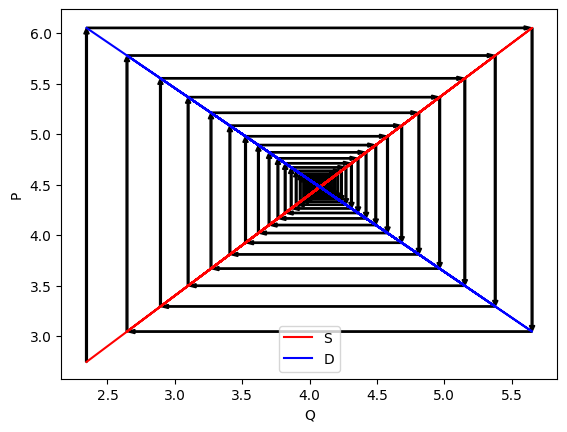


Precio inicial: 5.928446165269344 



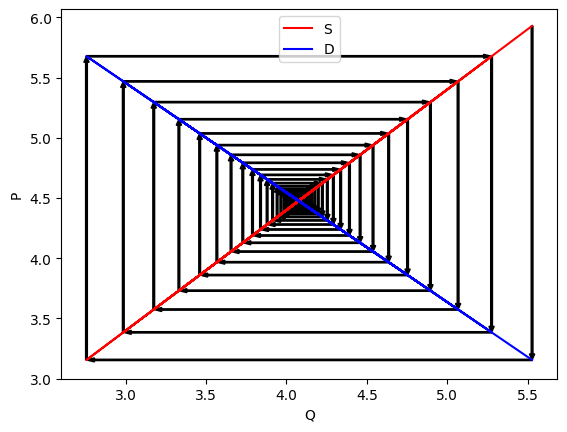

In [55]:
# Con condiciones iniciales aleatorias
P_0_random = generador.uniform() * 5
print("\nPrecio inicial:", P_0_random, "\n")
P, Q_d, Q_s = simular(a, b, c, d, P_0_random, periodo)
graficar(P, Q_d, Q_s)
plt.show()

P_0_random = generador.uniform() * 10
print("\nPrecio inicial:", P_0_random, "\n")
P, Q_d, Q_s = simular(a, b, c, d, P_0_random, periodo)
graficar(P, Q_d, Q_s)
plt.show()

Como se puede ver en los gráficos, el sistema converge al punto de equilibrio para cualquier valor del precio inicial. Esto es así porque la convergencia depende de los parámetros b y d, ya que estos determinan la pendiente de las rectas de oferta y demanda. Si el precio inicial se encuentra por debajo del precio de equilibrio, la fluctuacion comienza con una subida del precio, en cambio, si el precio inicial se encuentra por encima del precio de equilibrio, la fluctuacion comienza con una bajada del precio.

### d. Graficar la variable precio en función del período (t) para 100 períodos.

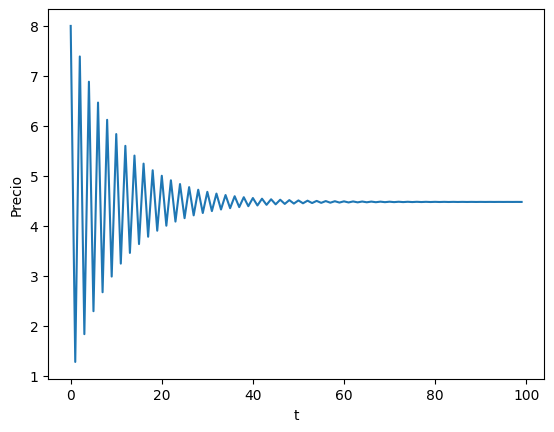

In [56]:
plt.plot(precio_en_funcion_del_periodo(9, 1.1, 0.4, 1, 8, 100))
plt.ylabel("Precio")
plt.xlabel("t")
plt.show()

### e. Graficar las trayectorias en el espacio de fases del sistema a través de 100 períodos para pares ordenados (Qt , Pt)

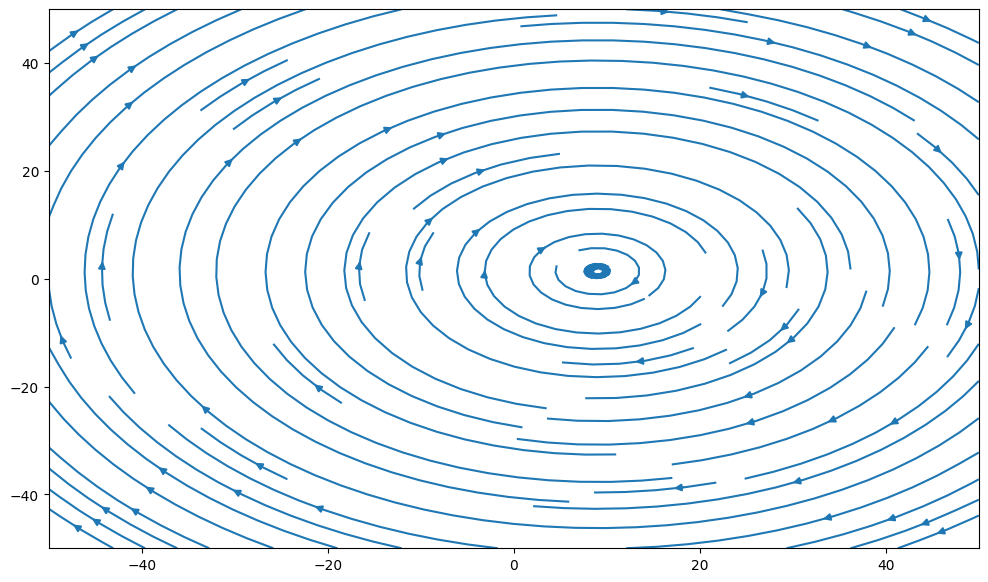

In [57]:
# P(t) = (a - Q(t)) / b
# Q(t) = d * P(t-1) - c

Y, X = np.mgrid[-50:50:100j, -50:50:100j]
U = d * (Y - 1) - c
V = (a - X) / b
fig = plt.figure(figsize=(12, 7))
plt.streamplot(X, Y, U, V, density=1)
plt.show()

### f. Simular, utilizando el generador de números al azar implementado en el TP 1, el sistema distintos valores de los parámetros a,b,c,d y P0 y vuelva a realizar los ítems a,b,c,d, y e para cada juego de parámetros probados.


Parámetros:

a: 5.488135024320365
b: 5.928446165269344
c: 7.15189365138111
d: 8.442657442866512

Condicion inicial:

P_0: 6.027633705182847 


Punto de equilibrio: ( 0.8795447462048515 ,  0.27380134649941557 )

El punto de equilibrio es inestable

Simulamos el sistema para distintos valores de P_O:

Precio inicial: 8.57945620049244 



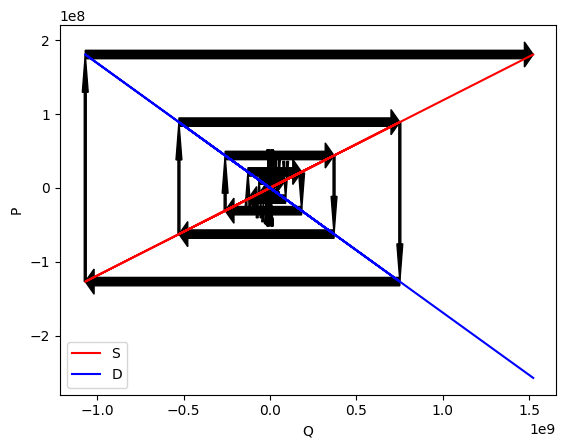


Precio inicial: 5.4488317750973705 



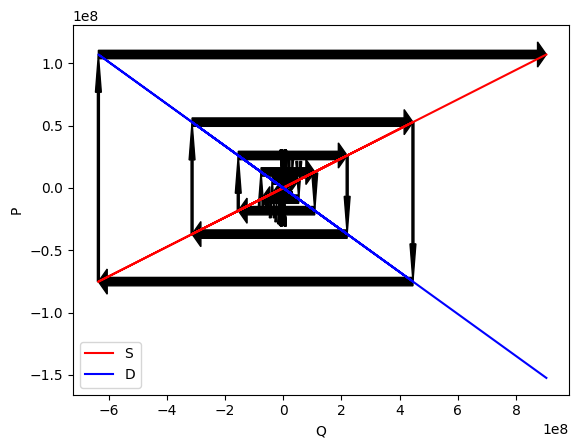


Graficamos la variable precio en función del período (t) para 100 períodos:



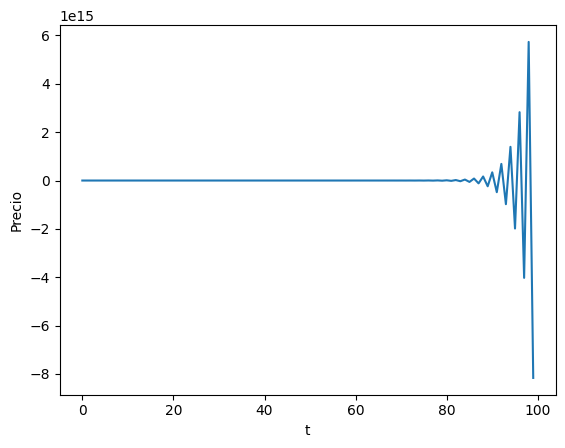


Parámetros:

a: 8.47251737454732
b: 4.236547968871088
c: 6.235636965426532
d: 6.458941152426167

Condicion inicial:

P_0: 3.8438170831286858 


Punto de equilibrio: ( 1.3751736057293937 ,  2.6465284283493267 )

El punto de equilibrio es inestable

Simulamos el sistema para distintos valores de P_O:

Precio inicial: 4.375872100790933 



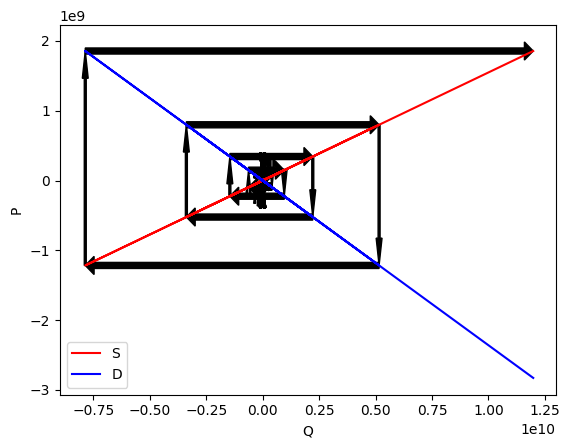


Precio inicial: 2.975346053246257 



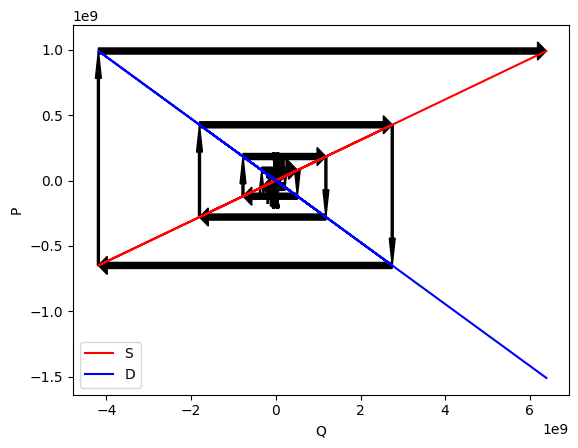


Graficamos la variable precio en función del período (t) para 100 períodos:



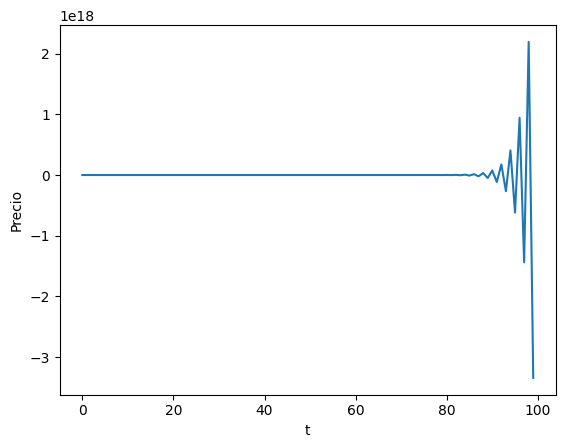


Parámetros:

a: 8.917730019641512
b: 0.567129757387361
c: 9.636627642818873
d: 2.726562945807018

Condicion inicial:

P_0: 3.8344152140976897 


Punto de equilibrio: ( 5.633299562058563 ,  5.722918205720907 )

El punto de equilibrio es inestable

Simulamos el sistema para distintos valores de P_O:

Precio inicial: 4.776651117665845 



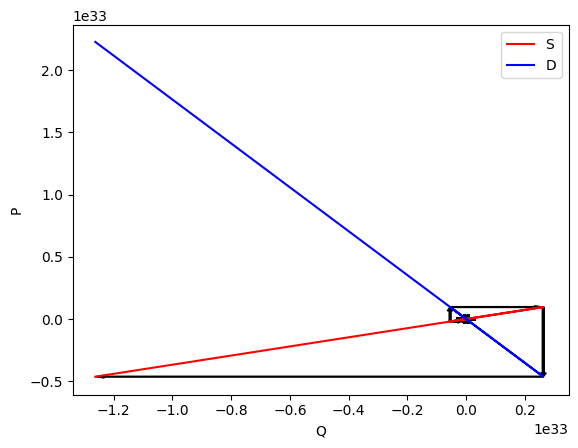


Precio inicial: 7.917250336128578 



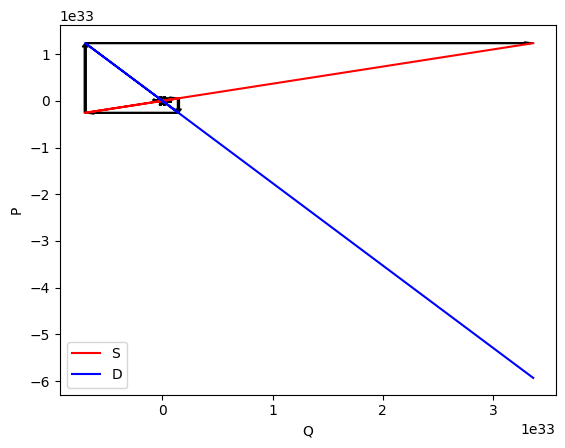


Graficamos la variable precio en función del período (t) para 100 períodos:



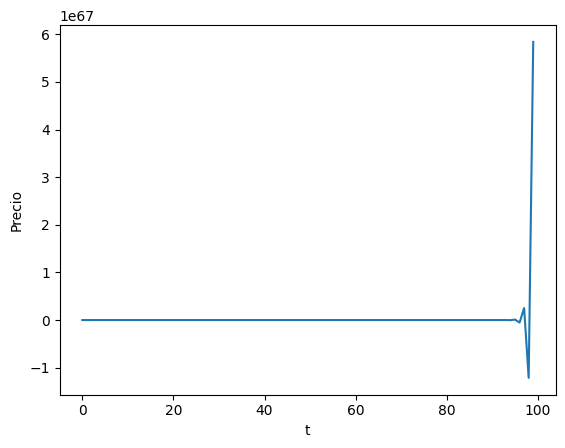


Parámetros:

a: 8.121687266538313
b: 5.288949216550437
c: 4.799771715141779
d: 5.680445638876512

Condicion inicial:

P_0: 3.9278479325417077 


Punto de equilibrio: ( 1.1779554981820524 ,  1.8915404572970687 )

El punto de equilibrio es inestable

Simulamos el sistema para distintos valores de P_O:

Precio inicial: 9.255966334430493 



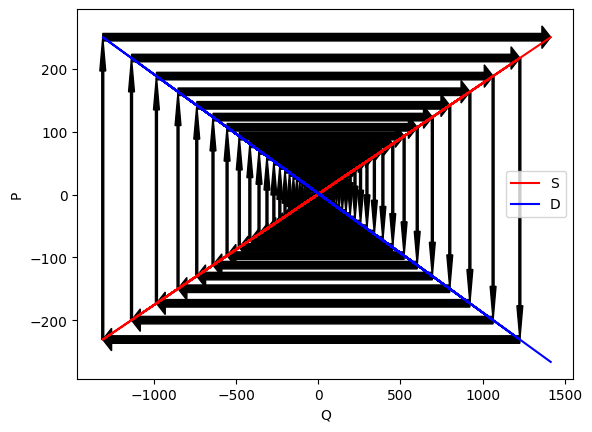


Precio inicial: 8.360787690235485 



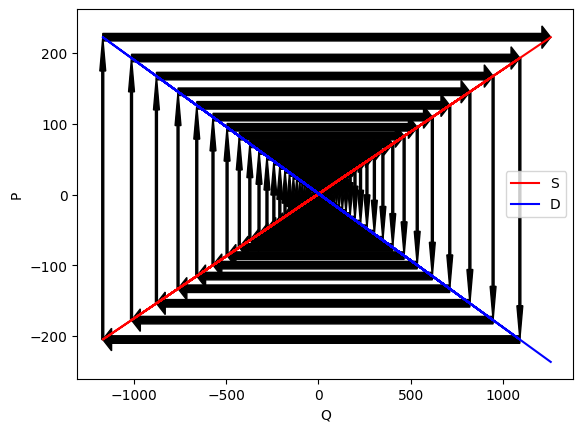


Graficamos la variable precio en función del período (t) para 100 períodos:



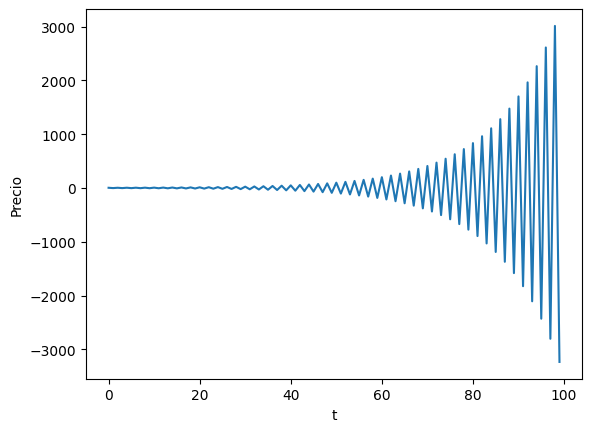


Parámetros:

a: 0.710360587274274
b: 3.373961617093059
c: 0.871292969880461
d: 6.4817187670808565

Condicion inicial:

P_0: 0.20218399125202186 


Punto de equilibrio: ( 0.16048141736561664 ,  0.16890244482599193 )

El punto de equilibrio es inestable

Simulamos el sistema para distintos valores de P_O:

Precio inicial: 3.68241537448075 



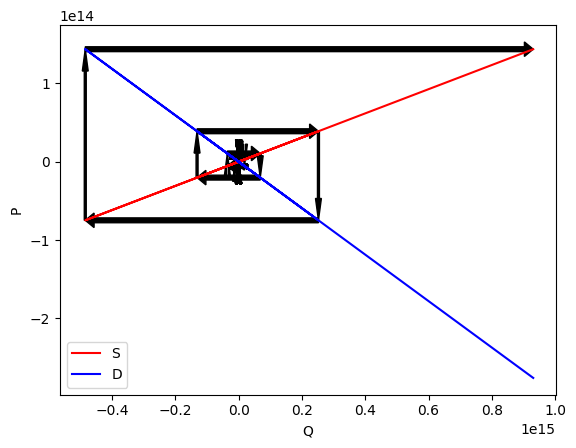


Precio inicial: 8.32619843034218 



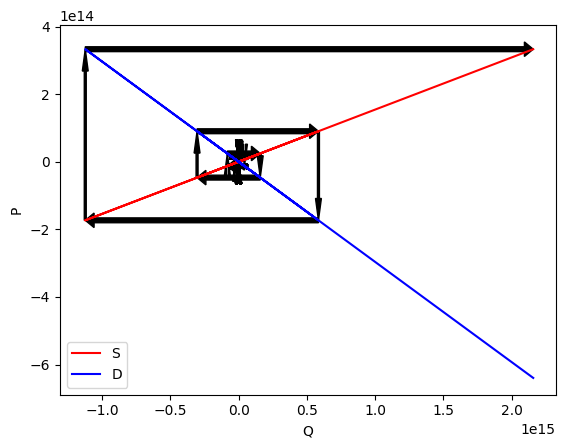


Graficamos la variable precio en función del período (t) para 100 períodos:



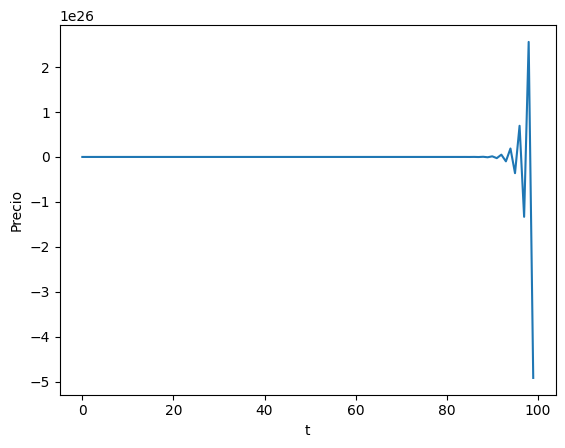

In [58]:
seed = 0
generador = MersenneTwister(seed)
for i in range(5):
    a_rand = generador.uniform() * 10
    b_rand = generador.uniform() * 10
    c_rand = generador.uniform() * 10
    d_rand = generador.uniform() * 10
    P_0_rand = generador.uniform() * 10
    print("\nParámetros:\n")
    print("a:", a_rand)
    print("b:", b_rand)
    print("c:", c_rand)
    print("d:", d_rand)
    print("\nCondicion inicial:\n")
    print("P_0:", P_0_rand, "\n")
    # Fórmula del punto de equilibrio obtenida en el punto a):
    # (P, Q) = ((a+c)/(b+d), d*(a+c)/(b+d) - c)
    P_eq, Q_eq = (
        (a_rand + c_rand) / (b_rand + d_rand),
        d_rand * (a_rand + c_rand) / (b_rand + d_rand) - c_rand,
    )
    print("\nPunto de equilibrio:", "(", P_eq, ", ", Q_eq, ")")
    # Analizamos la estabilidad según los autovalores obtenidos en el punto a):
    # λ1 = 0, λ2 = -(d/b)
    if d_rand > b_rand:
        print("\nEl punto de equilibrio es inestable")
    if d_rand < b_rand:
        print("\nEl punto de equilibrio es estable")
    if d_rand == b_rand:
        print("\nHay un ciclo límite")
    print("\nSimulamos el sistema para distintos valores de P_O:")
    for i in range(2):
        P_inicial = generador.uniform() * 10
        print("\nPrecio inicial:", P_inicial, "\n")
        P, Q_d, Q_s = simular(a_rand, b_rand, c_rand, d_rand, P_inicial, periodo)
        graficar(P, Q_d, Q_s)
        plt.show()
    print(
        "\nGraficamos la variable precio en función del período (t) para 100 períodos:\n"
    )
    plt.plot(
        precio_en_funcion_del_periodo(a_rand, b_rand, c_rand, d_rand, P_0_rand, 100)
    )
    plt.ylabel("Precio")
    plt.xlabel("t")
    plt.show()